In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from aggregate import aggregate
import numpy as np

In [3]:
import pandas as pd

WINDOWS = pd.read_csv(
  f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.B.paternal_recombination_rate.maternal_recombination_rate.gBGC-tract-counts.non-exonic.bed', 
  sep='\t', 
)
WINDOWS 

,chrom,start,end,gnocchi,N_expected,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,gBGC-tract_overlap_count,log10_paternal_recombination_rate,log10_maternal_recombination_rate
0,chr1,1432000,1433000,4.299894,338.059552,259,True,False,0.653,0.039046,0.025852,0,-1.408422,-1.587499
1,chr1,1451000,1452000,0.666316,302.590657,291,False,False,0.652,0.039046,0.025852,0,-1.408422,-1.587499
2,chr1,1453000,1454000,0.828398,269.601925,256,False,False,0.651,0.039046,0.025852,0,-1.408422,-1.587499
3,chr1,1458000,1459000,-0.086128,270.583243,272,False,False,0.651,0.039046,0.025852,0,-1.408422,-1.587499
4,chr1,1463000,1464000,2.948188,236.321790,191,True,False,0.651,0.039046,0.025852,0,-1.408422,-1.587499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024009,chr9,137262000,137263000,-2.396149,263.131293,302,True,False,0.536,0.057053,0.063434,0,-1.243724,-1.197675
1024010,chr9,137268000,137269000,3.640544,272.046527,212,True,False,0.536,0.057053,0.063434,0,-1.243724,-1.197675
1024011,chr9,137269000,137270000,5.276351,300.458958,209,True,False,0.536,0.057053,0.063434,0,-1.243724,-1.197675
1024012,chr9,137275000,137276000,2.687348,339.517045,290,True,False,0.536,1.564889,0.024254,0,0.194484,-1.615221


## For those non-exonic Chen windows subject to gBGC, the model overestimates the observed SNV count more often than it underestimates it 

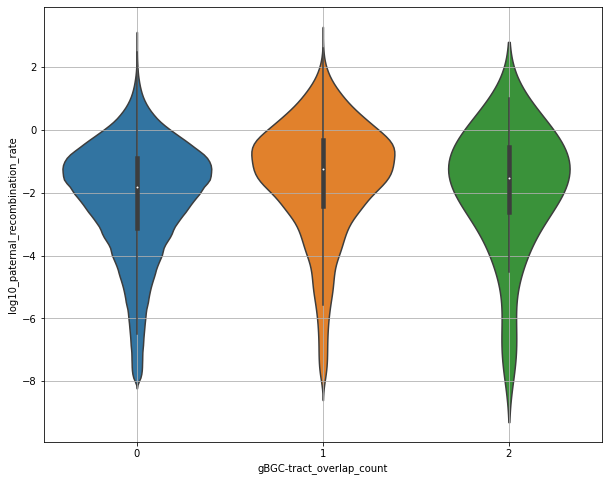

In [4]:
def correlate_recombination_rate_with_gBGC_tracts(df):
  plt.figure(figsize=(10, 8))  
  sns.violinplot(x='gBGC-tract_overlap_count', y='log10_paternal_recombination_rate', data=df)
  plt.grid(True) 

correlate_recombination_rate_with_gBGC_tracts(WINDOWS)

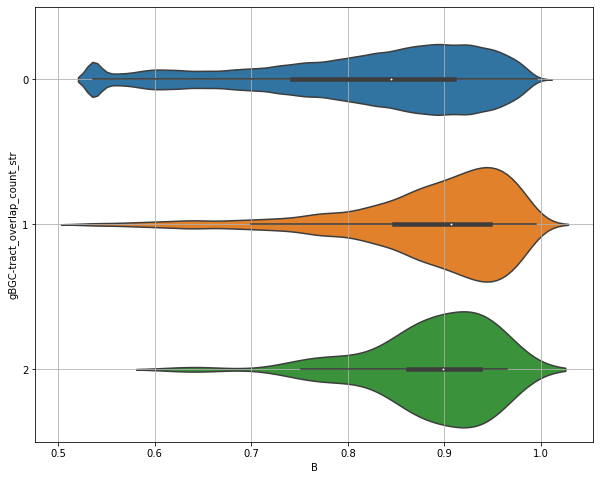

In [5]:
def correlate_BGS_with_gBGC_tracts(df):
  df = df.copy()
  df['gBGC-tract_overlap_count_str'] = df['gBGC-tract_overlap_count'].astype(str)

  plt.figure(figsize=(10, 8))  
  sns.violinplot(x='B', y='gBGC-tract_overlap_count_str', data=df)
  plt.grid(True) 

correlate_BGS_with_gBGC_tracts(WINDOWS)

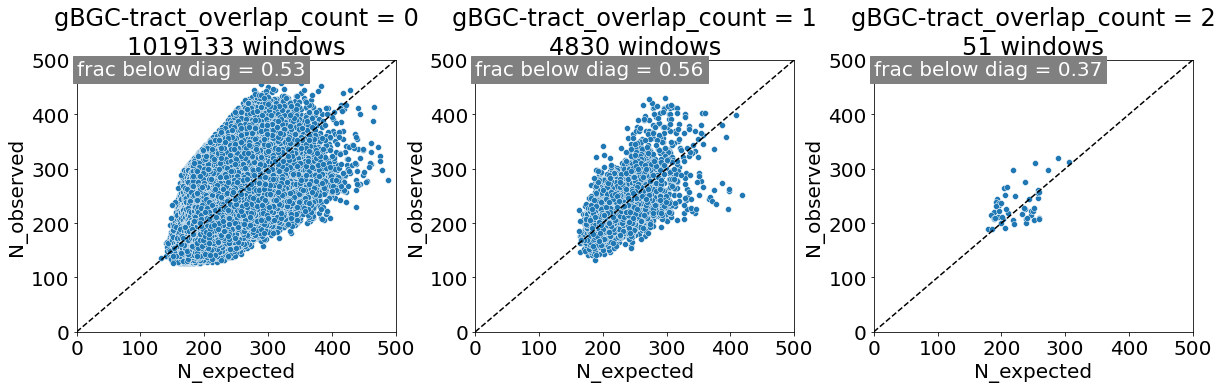

In [6]:
plt.rcParams.update({
  'font.size': 20,
})

def correlate_observed_counts_with_expected_counts(df): 
  feature = 'gBGC-tract_overlap_count'
  unique_feature_values = df[feature].unique()
  
  fig, axs = plt.subplots(1, len(unique_feature_values), figsize=(20, 5))
  plt.subplots_adjust(wspace=0.25)
  for i, feature_value in enumerate(sorted(unique_feature_values)): 
    df_for_feature_value = df[df[feature] == feature_value]
    sns.scatterplot(
      data=df_for_feature_value, 
      x='N_expected', 
      y='N_observed', 
      ax=axs[i],
    )
    axs[i].plot([0, 500], [0, 500], color='black', linestyle='--')
    axs[i].set_title(
      f'{feature} = {feature_value}\n'
      f'{len(df_for_feature_value)} windows'
    )

    fraction_below_diagonal = (df_for_feature_value['N_observed'] < df_for_feature_value['N_expected']).sum() / len(df_for_feature_value)
    axs[i].text(0, 500, f'frac below diag = {fraction_below_diagonal:.2f}', ha='left', va='top', backgroundcolor='grey', color='white')

    axs[i].set_xlim(0, 500)
    axs[i].set_ylim(0, 500)

correlate_observed_counts_with_expected_counts(WINDOWS)

## Gnocchi-based calls of constraint, but not enhancers, are enriched in regions overlapping gBGC tracts

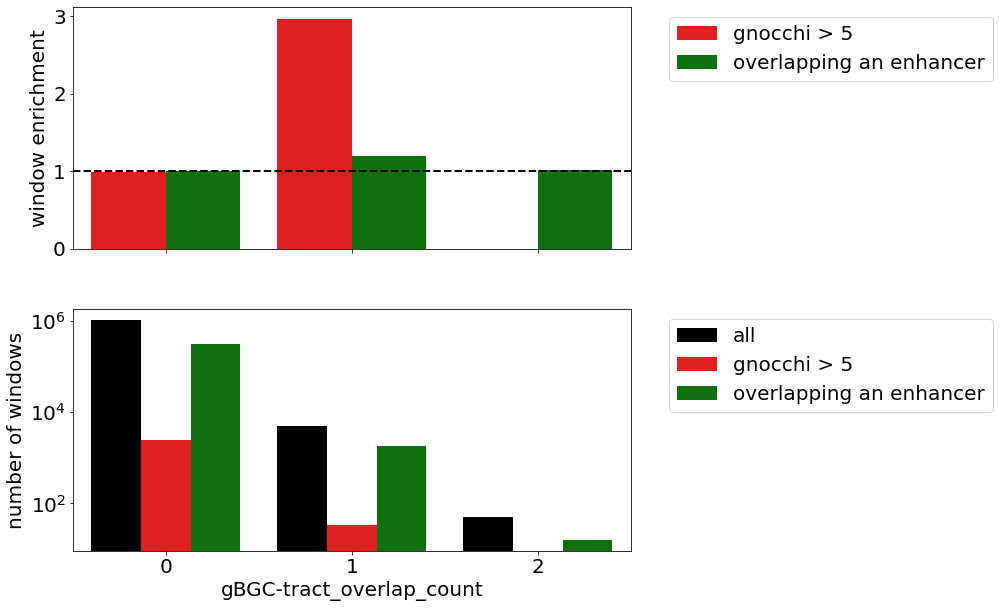

In [7]:
def plot_enrichment_of_windows(df, gnocchi_threshold): 
  feature = 'gBGC-tract_overlap_count'

  total_counts = df[feature].value_counts().sort_index()
  total_frac = total_counts/total_counts.sum()

  gnocchi_greater_than_threshold = df[df['gnocchi'] > gnocchi_threshold]
  gnocchi_counts = gnocchi_greater_than_threshold[feature].value_counts().sort_index()
  gnocchi_frac = gnocchi_counts / gnocchi_counts.sum() 

  enhancers = df[df['window overlaps enhancer'] == True]
  enhancer_counts = enhancers[feature].value_counts().sort_index()
  enhancer_frac = enhancer_counts / enhancer_counts.sum() 

  gnocchi_enrichment = gnocchi_frac / total_frac
  enhancer_enrichment = enhancer_frac / total_frac

  # Define color palette
  palette = {
      'all': 'black',
      f'gnocchi > {gnocchi_threshold}': 'red',
      'overlapping an enhancer': 'green'
  }

  plt.rcParams.update({'font.size': 20})

  fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
  fig.subplots_adjust(hspace=0.25)

  melt1 = pd.DataFrame({
      'gBGC-tract overlap count': gnocchi_enrichment.index,
      f'gnocchi > {gnocchi_threshold}': gnocchi_enrichment,
      f'overlapping an enhancer': enhancer_enrichment
  }).melt(id_vars='gBGC-tract overlap count', var_name='type', value_name='enrichment')
  sns.barplot(x='gBGC-tract overlap count', y='enrichment', hue='type', data=melt1, ax=axs[0], alpha=1.0, palette=palette)

  axs[0].set_ylabel('window enrichment')
  axs[0].axhline(y=1, color='black', linestyle='--', linewidth=2)
  axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside of plot
  axs[0].set_xlabel(None)

  melt2 = pd.DataFrame({
      'gBGC-tract_overlap_count': total_counts.index,
      'all': total_counts,
      f'gnocchi > {gnocchi_threshold}': gnocchi_counts,
      f'overlapping an enhancer': enhancer_counts
  }).melt(id_vars='gBGC-tract_overlap_count', var_name='type', value_name='count')
  sns.barplot(x='gBGC-tract_overlap_count', y='count', hue='type', data=melt2, ax=axs[1], alpha=1, palette=palette)

  axs[1].set_yscale('log')  
  axs[1].set_ylabel('number of windows')
  axs[1].set_xlabel(feature)
  axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside of plot

plot_enrichment_of_windows(WINDOWS, gnocchi_threshold=5)